In [1]:
# 환경 세팅
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
drive.mount('/content/drive')

# 'MyDrive' 경로를 추가해야 해!
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/credit_preprocessing_total.parquet', engine='pyarrow')
# 잘 불러와졌는지 확인
print("데이터 로드 완료!")
df.info()

df_test = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/test_preprocessing_total.parquet', engine='pyarrow')
# 잘 불러와졌는지 확인
print("데이터 로드 완료!")
df_test.info()

Mounted at /content/drive
데이터 로드 완료!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400000 entries, 0 to 2399999
Columns: 858 entries, 기준년월 to 혜택수혜율_B0M
dtypes: float32(57), float64(4), int16(148), int32(147), int8(452), object(50)
memory usage: 4.5+ GB
데이터 로드 완료!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Columns: 857 entries, 기준년월 to 혜택수혜율_B0M
dtypes: float32(57), float64(4), int16(153), int32(139), int8(455), object(49)
memory usage: 1.1+ GB


In [2]:
pkgs_path = '/content/drive/MyDrive/colab_pip'

# 경로를 리스트의 가장 앞(0번 인덱스)에 추가해서 우선순위를 높임
if pkgs_path not in sys.path:
    sys.path.insert(0, pkgs_path)

try:
    import catboost
    print(f"성공! 버전: {catboost.__version__}")
except ImportError:
    print("여전히 못 찾고 있어. 폴더 구조를 다시 확인해봐야 할 것 같아.")


성공! 버전: 1.2.8


In [3]:
# 경로 설정
save_path = '/content/drive/MyDrive/Colab Notebooks/'

# 불러오기 코드
loaded_mapping = {}
target_lists = ['Missing>50%', 'Constant', 'Imbalanced', 'FinalDrop']

for list_name in target_lists:
    file_name = f"{list_name}.txt"
    full_path = os.path.join(save_path, file_name)

    try:
        with open(full_path, 'r', encoding='utf-8') as f:
            loaded_mapping[list_name] = [line.strip() for line in f.readlines()]
        print(f"📂 드라이브에서 불러오기 성공: {file_name}")
    except FileNotFoundError:
        print(f"❌ 파일을 찾을 수 없어: {full_path}")

# 변수 재할당
over_50_missing_cols = loaded_mapping.get('Missing>50%', [])
constant_cols = loaded_mapping.get('Constant', [])
imbalanced_col_names = loaded_mapping.get('Imbalanced', [])
final_drop_list = loaded_mapping.get('FinalDrop', [])

# 1. 파일 경로 설정 (주신 코드를 그대로 활용했어!)
full_path = os.path.join(save_path, 'zero_importance_features 5000.txt')

# 2. 파일 읽어서 zero_importance_features 리스트에 할당하기
try:
    with open(full_path, 'r', encoding='utf-8') as f:
        # strip()을 사용해 양쪽 공백과 줄바꿈을 제거하고, 빈 줄은 제외하는 방식이야
        zero_importance_features = [line.strip() for line in f if line.strip()]

    print(f"성공적으로 {len(zero_importance_features)}개의 피처를 불러왔어! 😊")

except FileNotFoundError:
    print("어라, 파일 경로가 맞는지 확인해봐야 할 것 같아! 파일을 찾을 수 없대. 😅")

# set으로 변환해서 교집합 찾기
suspect = list(set(over_50_missing_cols) | set(imbalanced_col_names)) #여기를 변경

print(f"공통 항목 개수: {len(suspect)}개")
print(f"의심 항목 리스트: {suspect}")

📂 드라이브에서 불러오기 성공: Missing>50%.txt
📂 드라이브에서 불러오기 성공: Constant.txt
📂 드라이브에서 불러오기 성공: Imbalanced.txt
📂 드라이브에서 불러오기 성공: FinalDrop.txt
성공적으로 165개의 피처를 불러왔어! 😊
공통 항목 개수: 369개
의심 항목 리스트: ['RV신청일자', '여유_Pet이용금액', '_3순위여유업종_이용금액', '최종카드론_금융상환방식코드', '연체원금_B2M', '포인트_잔여포인트_B0M', '증감_RP건수_전기_전월', '증감_RP건수_건강_전월', '인입횟수_IB_B0M', '컨택건수_포인트소진_TM_R6M', '연체일자_B0M', '이용건수_당사기타_R6M', '당사PAY_방문월수_R6M', '임직원면제카드수_B0M', 'OS구분코드', '탈회횟수_발급6개월이내', 'RP후경과월_전기', '이용금액_카드론_R3M', '유효카드수_신용_가족', 'IB문의건수_SMS_R6M', 'IB문의건수_CA_R6M', '이용금액_D페이_R6M', 'IB문의건수_결제일변경_B0M', '이용메뉴건수_IB_B0M', '이용건수_당사페이_R3M', '이용횟수_연체_B0M', '최종연체개월수_R15M', '연회비발생카드수_B0M', '할부건수_부분_6M_R12M', '방문일수_모바일웹_B0M', '여유_여행이용금액', '이용개월수_부분무이자_R3M', 'IB문의건수_카드발급_B0M', '제휴연회비_B0M', '이용금액_카드론_B0M', '한도심사요청후경과월', 'IB문의건수_한도_B0M', '이용금액_당사페이_B0M', '시장연체상환여부_R6M', '이용금액_D페이_R3M', '할인금액_제휴연회비_B0M', '최대이용금액_부분무이자_R12M', '_3순위납부업종', '연체잔액_CA_B0M', '이용가능카드수_신용_가족', '인입불만후경과월_IB_R6M', '이용금액_당사기타_R3M', '이용금액_연체_B0M', '신청건수_ATM_CA_B0', '승인거절건수_한도초과_B0M', '이용건수_D페이

In [4]:
# import pandas as pd
# import numpy as np
# from catboost import CatBoostClassifier, Pool
# from sklearn.model_selection import train_test_split
# from sklearn.utils.class_weight import compute_class_weight

# # 0. 클래스 별 가중치 계산 (데이터가 적을수록 높은 가중치)


# # 1. 타겟 매핑 및 컬럼 제거
# target_map = {'A': 5, 'B': 4, 'C': 3, 'D': 2, 'E': 1}
# df['Segment'] = df['Segment'].map(target_map)
# df = df.dropna(subset=['Segment'])

# drop_cols = ['ID', '기준년월'] + suspect #여기를 변경
# X = df.drop(columns=drop_cols + ['Segment'])
# y = df['Segment']
# X_test = df_test.drop(columns=drop_cols)

# # --- [수정 포인트 1] fillna 제거 및 타입 강제 변환 ---
# # 800개 컬럼에 fillna를 하는 대신, CatBoost가 인식할 수 있게 문자열 타입으로만 바꿉니다.
# # 'None'으로 채우는 것보다 astype(str)이 더 효율적이며, 결측치는 자동으로 'nan' 문자열이 됩니다.
# cat_features = X.columns[X.dtypes == 'object'].tolist()
# for col in cat_features:
#     X[col] = X[col].astype(str)
#     X_test[col] = X_test[col].astype(str)

# # 2. Train-Validation Split
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # 3. CatBoost Pool 생성
# # 이미 문자열 처리가 끝났으므로 Pool 생성 속도가 훨씬 빨라집니다.
# train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
# val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)
# test_pool = Pool(data=X_test, cat_features=cat_features)

# classes = np.unique(y)
# weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
# class_weights_dict = dict(zip(classes, weights))

# # 4. [수정 포인트 2] GPU 학습 가속 파라미터 적용
# model = CatBoostClassifier(
#     iterations=5000,
#     early_stopping_rounds=200,
#     task_type='GPU',
#     devices='0',
#     learning_rate=0.05,
#     depth=6,
#     eval_metric='MultiClass',
#     class_weights=class_weights_dict, # 가중치 적용
#     random_seed=42,
#     verbose=500,
#     # --- 속도 향상을 위한 핵심 옵션 ---
#     bootstrap_type='Poisson',      # GPU에서 가장 빠른 샘플링 방식
#     max_ctr_complexity=1,         # 범주형 변수 결합 연산을 단순화 (800개 컬럼일 때 필수)
#     gpu_ram_part=0.8,             # GPU 메모리 점유율 확대 (학습 속도 향상)
#     border_count=32               # 수치형 변수의 분기점 개수 제한 (속도 대폭 상승, 성능 타격 적음)
# )

# model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=200)


In [5]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold # 여기가 핵심!
from sklearn.utils.class_weight import compute_class_weight

# 1. 타겟 매핑 및 컬럼 제거
# (이 부분은 기존과 동일)
target_map = {'A': 5, 'B': 4, 'C': 3, 'D': 2, 'E': 1}
# 주의: 만약 df가 이미 로드되어 있다고 가정할게!
df['Segment'] = df['Segment'].map(target_map)
df = df.dropna(subset=['Segment'])

drop_cols = ['ID', '기준년월'] + suspect # suspect 변수가 있다면 추가
X = df.drop(columns=drop_cols + ['Segment'])
y = df['Segment']

# 테스트 데이터 처리 (df_test가 있다고 가정)
X_test = df_test.drop(columns=drop_cols)

# --- [전처리] fillna 제거 및 타입 강제 변환 ---
cat_features = X.columns[X.dtypes == 'object'].tolist()
for col in cat_features:
    X[col] = X[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# --- [클래스 가중치 계산] ---
# 전체 데이터에 대해 한번 계산하거나, Fold 내부에서 계산할 수도 있어.
# 여기선 편의상 전체 분포를 기준으로 할게.
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights_dict = dict(zip(classes, weights))




In [6]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# # 1. 모델에게 검증 데이터(X_val)를 주고 예측해보라고 시키기
# y_pred = model.predict(X_val)

# print("\n=== Soft Voting 계층적 분류 최종 성적표 ===")
# print(classification_report(y_val, y_pred))

# # 2. 실제 정답(y_val)과 모델의 예측(y_pred)을 비교해서 행렬 만들기
# cm = confusion_matrix(y_val, y_pred)

# # 3. 시각화할 때 라벨 달아주기
# plt.figure(figsize=(10, 8))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix: Model Performance Review')
# plt.show()

In [7]:
# # 5. 예측 및 타겟 복원 (A, B, C, D, E)
# inv_target_map = {5: 'A', 4: 'B', 3: 'C', 2: 'D', 1: 'E'}

# df_test['pred_label'] = model.predict(test_pool)
# df_test['pred_label'] = df_test['pred_label'].map(inv_target_map)

# # 6. 제출 파일 생성
# submission = df_test.groupby("ID")["pred_label"] \
#     .agg(lambda x: x.value_counts().idxmax()) \
#     .reset_index()

# submission.columns = ["ID", "Segment"]
# submission.to_csv('/content/drive/MyDrive/Colab Notebooks/submission.csv', index=False)

# # 7. 특성 중요도가 0인 컬럼 저장
# feature_importances = model.get_feature_importance()
# zero_importance_features = [X.columns[i] for i, score in enumerate(feature_importances) if score == 0]

# with open('/content/drive/MyDrive/Colab Notebooks/zero_importance_features.txt', 'w') as f:
#     for feature in zero_importance_features:
#         f.write(f"{feature}\n")

# print(f"학습 완료! 중요도가 0인 컬럼 {len(zero_importance_features)}개를 저장했습니다.")

총 5개의 Fold로 학습을 시작합니다...

=== Fold 1 / 5 진행 중 ===
0:	learn: 1.5137537	test: 1.5160345	best: 1.5160345 (0)	total: 137ms	remaining: 11m 26s
1000:	learn: 0.2634245	test: 0.3360071	best: 0.3358011 (984)	total: 1m 32s	remaining: 6m 9s
bestTest = 0.3250779237
bestIteration = 1179
Shrink model to first 1180 iterations.
=== Fold 2 / 5 진행 중 ===
0:	learn: 1.5113951	test: 1.5124557	best: 1.5124557 (0)	total: 117ms	remaining: 9m 44s
1000:	learn: 0.2647588	test: 0.3048766	best: 0.3048459 (998)	total: 1m 33s	remaining: 6m 13s
2000:	learn: 0.2311028	test: 0.2762673	best: 0.2757051 (1981)	total: 3m 3s	remaining: 4m 35s
3000:	learn: 0.2111735	test: 0.2616523	best: 0.2612140 (2938)	total: 4m 34s	remaining: 3m 2s
4000:	learn: 0.1965484	test: 0.2515079	best: 0.2512502 (3968)	total: 6m 4s	remaining: 1m 30s
4999:	learn: 0.1848545	test: 0.2429999	best: 0.2429999 (4999)	total: 7m 34s	remaining: 0us
bestTest = 0.24299995
bestIteration = 4999
=== Fold 3 / 5 진행 중 ===
0:	learn: 1.5077494	test: 1.5162121	best: 1.5

<Figure size 1000x800 with 0 Axes>

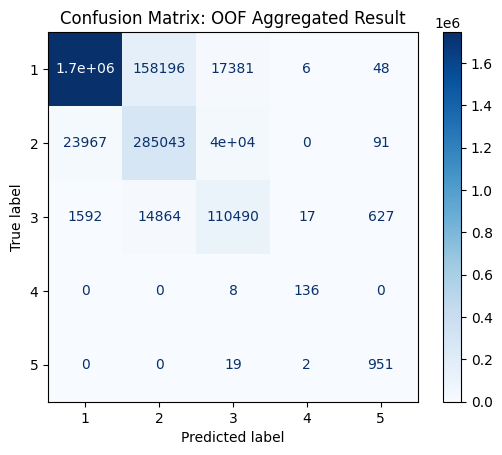

제출 파일 생성 완료!
중요도가 0인 컬럼 2개를 저장했습니다.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils.class_weight import compute_class_weight

# --- [0. 준비 단계] (데이터 로드 및 전처리는 되어 있다고 가정) ---
# X: 학습 데이터 (ID 제외)
# y: 타겟 라벨 (1~5로 매핑됨)
# df_test: 테스트 데이터 원본 (ID 포함)
# X_test: 테스트 데이터 (ID 제외, 모델 입력용)

# K-Fold 설정
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 결과 저장을 위한 그릇들 준비
oof_pred = np.zeros(len(y))  # 학습 데이터 전체 크기만큼 0으로 채움 (검증 결과 모을 곳)
final_proba = np.zeros((len(X_test), 5)) # 테스트 데이터 예측 확률 누적할 곳 (클래스 5개)
feature_importance_sum = np.zeros(X.shape[1]) # 특성 중요도 누적할 곳

# 클래스 가중치 계산
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights_dict = dict(zip(classes, weights))

print(f"총 {n_splits}개의 Fold로 학습을 시작합니다...\n")

# --- [1. K-Fold 학습 루프] ---
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"=== Fold {fold+1} / {n_splits} 진행 중 ===")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)

    model = CatBoostClassifier(
        iterations=5000,
        early_stopping_rounds=200,
        task_type='GPU',
        devices='0',
        learning_rate=0.05,
        depth=6,
        eval_metric='MultiClass',
        class_weights=class_weights_dict,
        random_seed=42,
        verbose=1000, # 로그 줄임
        bootstrap_type='Poisson',
        max_ctr_complexity=1,
        gpu_ram_part=0.8,
        border_count=32
    )

    model.fit(train_pool, eval_set=val_pool)

    # [중요] 1. OOF 예측: 현재 Fold의 검증 데이터에 대한 예측값을 전체 배열의 제자리에 넣음
    # flatten()을 써서 차원을 맞춰줍니다.
    oof_pred[val_idx] = model.predict(val_pool).flatten()

    # [중요] 2. Test 데이터 확률 누적 (Soft Voting)
    test_pool = Pool(X_test, cat_features=cat_features)
    final_proba += model.predict_proba(test_pool) / n_splits

    # [중요] 3. 특성 중요도 누적
    feature_importance_sum += model.get_feature_importance()

print("\n모든 Fold 학습 완료!")

# --- [2. 모델 평가 (OOF 결과 활용)] ---
# 이제 y_pred 대신 oof_pred를 사용합니다. (전체 데이터에 대한 예측이 모였으므로)
print("\n=== K-Fold 종합 성적표 (OOF Performance) ===")
print(classification_report(y, oof_pred))

# Confusion Matrix
cm = confusion_matrix(y, oof_pred)

plt.figure(figsize=(10, 8))
# labels는 모델의 클래스 순서 (보통 1,2,3,4,5 순으로 정렬됨)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: OOF Aggregated Result')
plt.show()

# --- [3. 최종 예측 및 제출 파일 생성] ---
# 확률이 가장 높은 클래스의 인덱스를 찾음
final_preds_indices = np.argmax(final_proba, axis=1)
# 인덱스를 실제 클래스 값(1~5)으로 변환
final_preds_numeric = model.classes_[final_preds_indices]

# 숫자 -> 문자(A~E) 복원
inv_target_map = {5: 'A', 4: 'B', 3: 'C', 2: 'D', 1: 'E'}

# df_test에 예측값 넣기
df_test['pred_label'] = final_preds_numeric
df_test['pred_label'] = df_test['pred_label'].map(inv_target_map)

# 제출 파일 생성 (기존 코드 유지)
submission = df_test.groupby("ID")["pred_label"] \
    .agg(lambda x: x.value_counts().idxmax()) \
    .reset_index()

submission.columns = ["ID", "Segment"]
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/submission.csv', index=False)
print("제출 파일 생성 완료!")

# --- [4. 평균 특성 중요도 저장] ---
# 5개 Fold의 중요도를 평균 냄
avg_feature_importance = feature_importance_sum / n_splits
zero_importance_indices = np.where(avg_feature_importance == 0)[0]
zero_importance_features = X.columns[zero_importance_indices]

with open('/content/drive/MyDrive/Colab Notebooks/zero_importance_features.txt', 'w') as f:
    for feature in zero_importance_features:
        f.write(f"{feature}\n")

print(f"중요도가 0인 컬럼 {len(zero_importance_features)}개를 저장했습니다.")